# Crop raster data with rioxarray and geopandas

It is quite common that the raster data you have in hand is too large to process, or not all the pixels are relevant to your area of interest (AoI). In both situations, you should consider cropping your raster data before performing data analysis.

In this episode, we will introduce how to crop raster data into the desired area. We will use one Sentinel-2 image over Rhodes Island as the example raster data, and introduce how to crop your data to different types of AoIs.


The sentinel-2 data was obtained from [the Sentinel-2 data collection that is hosted on Amazon Web Services (AWS)](https://registry.opendata.aws/sentinel-2-l2a-cogs). You can download every tile individually, but you can also use the API. This will be explained in a next episode. 

This dataset consists of multi-band optical images acquired by the two satellite constellations of
[the Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) and it is continuously updated with
new images.

## Search a STAC catalog

The [STAC browser](https://radiantearth.github.io/stac-browser/#/) is a good starting point to discover available
datasets, as it provides an up-to-date list of existing STAC catalogs. From the list, let's click on the
"Earth Search" catalog, i.e. the access point to search the archive of Sentinel-2 images hosted on AWS.

For this episode we will focus at scenes belonging to the `sentinel-2-l2a` collection. 
This dataset is useful for our case and includes Sentinel-2 data products pre-processed at level 2A (bottom-of-atmosphere reflectance). 

[link](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1)


https://radiantearth.github.io/stac-browser/#/search/external/earth-search.aws.element84.com/v1

First, we will load the visual image of Sentinel-2 over Rhodes Island, which we downloaded and stored in `data_workshop/sentinel2/visual.tif`. 

We can open this asset with `rioxarray`, and specify the overview level, since this is a Cloud-Optimized GeoTIFF (COG) file. As explained in episode 6 raster images can be quite big, therefore we decided to resample the data using ´rioxarray's´ overview parameter and set it to `overview_level=1`.  

In [1]:
import rioxarray
path_visual = 'data_workshop/sentinel2/visual.tif'
visual = rioxarray.open_rasterio(path_visual, overview_level=1)
visual

<xarray.DataArray (band: 3, y: 2745, x: 2745)> Size: 23MB
[22605075 values with dtype=uint8]
Coordinates:
  * band         (band) int32 12B 1 2 3
  * x            (x) float64 22kB 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 22kB 4.1e+06 4.1e+06 4.1e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

As we introduced in the raster data introduction episode, this will perform a "lazy" loading of the image meaning that the image will not be loaded into the memory until necessary.

Let's also load the assets file generated in the vector data episode:

In [2]:
import geopandas as gpd
assets = gpd.read_file('assets.gpkg')

<Axes: >

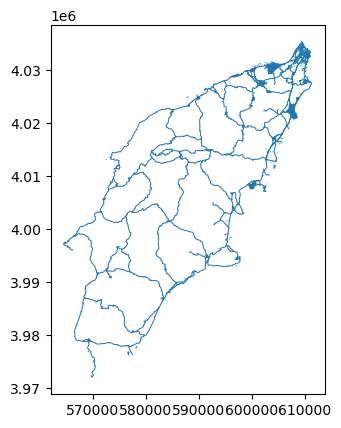

In [19]:
assets.plot()

### Crop the raster with a bounding box

The assets file contains the information of the vital infrastructure and built-up areas on the island Rhodes. The visual image, on the other hand, has a larger extent. Let us check this by visualizing the raster image:

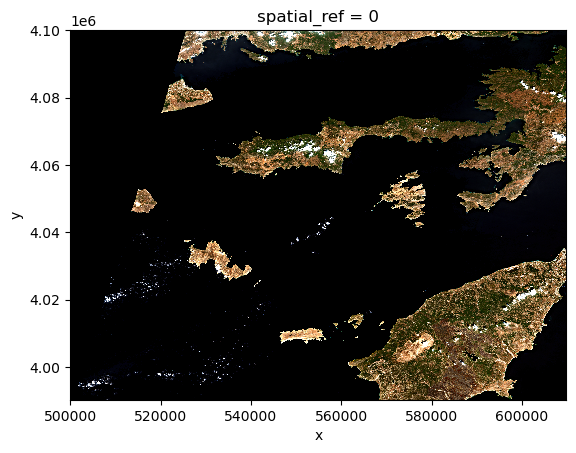

In [3]:
visual.plot.imshow()

Let's check the extent of the assets to find out its rough location in the raster image.
We can use the [`total_bounds`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html) attribute from `GeoSeries` of `geopandas` to get the bounding box:

In [4]:
assets.total_bounds

array([27.71628289, 35.89024659, 28.24128748, 36.4569273 ])

The bounding box is composed of the `[minx, miny, maxx, maxy]` values of the raster. Comparing these values with the raster image, we can identify that the magnitude of the bounding box coordinates does not match the coordinates of the raster image. This is because the two datasets have different coordinate reference systems (CRS). This will cause problems when cropping the raster image, therefore we first need to align the CRS-s of the two datasets 

Considering the raster image has larger data volume than the vector data, we will reproject the vector data to the CRS of the raster data. We can use the `to_crs` method:

In [5]:
# Reproject
assets = assets.to_crs(visual.rio.crs)

array([ 564461.41472579, 3972051.52011189,  611329.30664851,
       4035322.51020083])

Check the new bounding box

In [6]:
assets.total_bounds

array([ 564461.41472579, 3972051.52011189,  611329.30664851,
       4035322.51020083])

Now the bounding box coordinates are updated. We can use the `clip_box` function, through the `rioaxarray` accessor, to crop the raster image to the bounding box of the vector data. `clip_box` takes four positional input arguments in the order of `xmin`, `ymin`, `xmax`, `ymax`, which is exactly the same order in the `assets.total_bounds`. Since `assets.total_bounds` is an `numpy.array`, we can use the symbol `*` to unpack it to the relevant positions in `clip_box`.

In [7]:
# Crop the raster with the bounding box
visual_clipbox = visual.rio.clip_box(*assets.total_bounds)

Visualize the cropped image

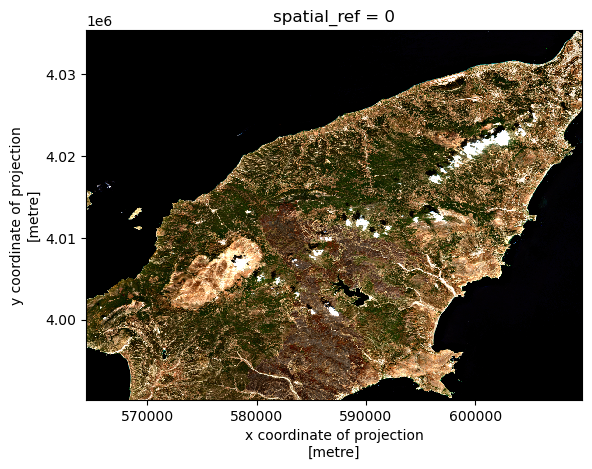

In [8]:
visual_clipbox.plot.imshow()

## Code Tip
Cropping a raster with a bounding box is a quick way to reduce the size of the raster data. Since this operation is based on min/max coordinates, it is not as computational extensive as cropping with polygons, which requires more accurate overlay operations.

### Crop the raster with a polygon
We can also crop the raster with a polygon. In this case, we will use the raster `clip` function through the `rio` accessor. For this we will use the `geometry` column of the `assets` GeoDataFrame to specify the polygon:

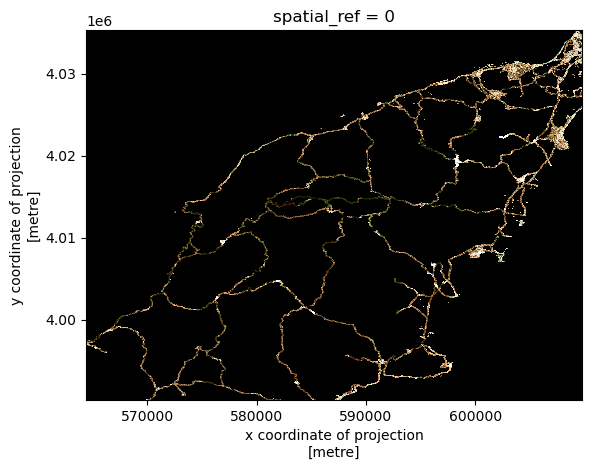

In [9]:
# Crop the raster with the polygon
visual_clip = visual_clipbox.rio.clip(assets["geometry"])

# Visualize the cropped image
visual_clip.plot.imshow()

# Exercise 8.1

Now that you have seen how clip a raster using a polygon, we want you to do this for the red band of the sattelite image. Use the shape of Rhodes from GADM and clip the red band with it. Furthermore, make sure to transform the no data values to Not a Number values.      

In [32]:
# Solution

# Step 1 - Load the datasets - Vector data

import geopandas as gpd
gdf_greece = gpd.read_file('./data_workshop/gadm/ADM_ADM_3.gpkg')
gdf_rhodes = gdf_greece.loc[gdf_greece['NAME_3']=='Rhodos']

# Step 2 - Load the raster red band
import rioxarray
path_red = './data_workshop/sentinel2/red.tif'
red = rioxarray.open_rasterio(path_red, overview_level=1)

<Axes: >

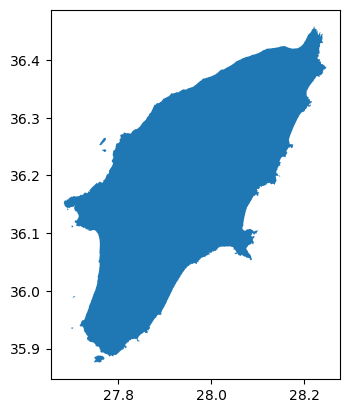

In [31]:
gdf_rhodes.plot()

In [33]:
# Step 3 - It will not work, since it is not projected yet

gdf_rhodes = gdf_rhodes.to_crs(red.rio.crs)


In [45]:
# Step 4 Clip the two

red_clip = red.rio.clip(gdf_rhodes["geometry"])

In [48]:
# Step 5 Check the results
print(red_clip)

<xarray.DataArray (band: 1, y: 1131, x: 1207)> Size: 3MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 10kB 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 9kB 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0


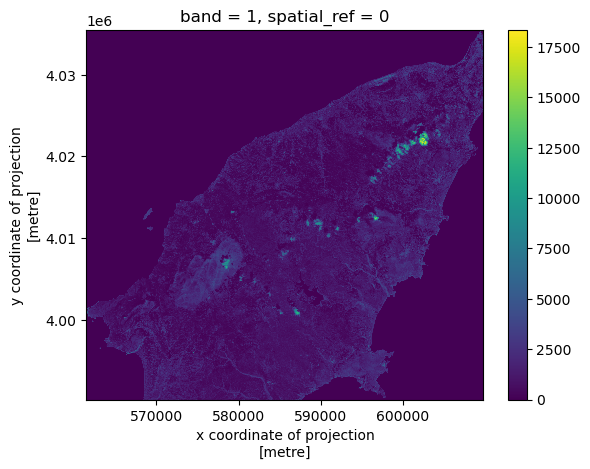

In [47]:
# Step 5 Check the results
red_clip.plot()

In [51]:
print(red_clip.rio.nodata)

0


In [52]:
red_clip_nan = red_clip.where(red_clip!=red_clip.rio.nodata)

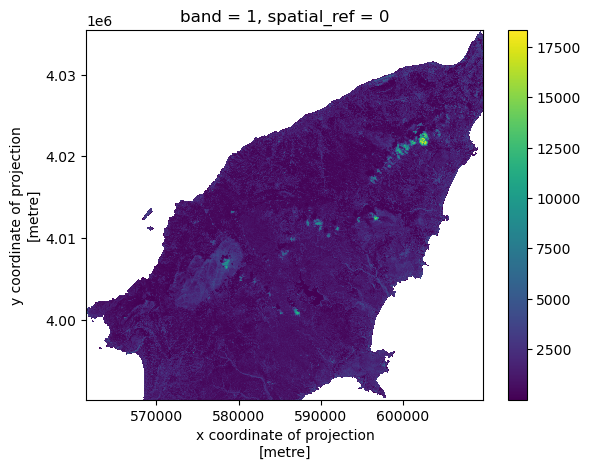

In [53]:
red_clip_nan.plot()

### Match two rasters

Sometimes you need to match two rasters with different extents, resolutions, or CRS. For this you can use the  [`reproject_match`](https://corteva.github.io/rioxarray/stable/examples/reproject_match.html#Reproject-Match) function . We will demonstrate this by matching the cropped raster `visual_clip` with the Digital Elevation Model (DEM),`rhodes_dem.tif` of Rhodes.

First, let's load the DEM:

In [10]:
dem = rioxarray.open_rasterio('./data_workshop/dem/rhodes_dem.tif')

And visualize it:

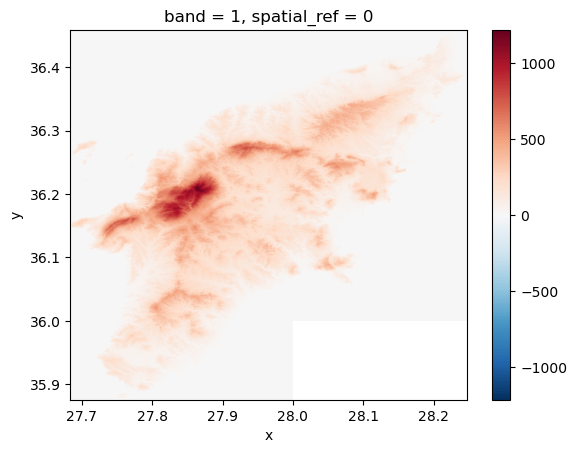

In [11]:
dem.plot()

From the visualization, we can see that the DEM has a different extent, resolution and CRS compared to the cropped visual image. We can also confirm this by checking the CRS of the two images:

In [12]:
print(dem.rio.crs)
print(visual_clip.rio.crs)

EPSG:4326
EPSG:32635


We can use the `reproject_match` function to match the two rasters. One can choose to match the dem to the visual image or vice versa. Here we will match the DEM to the visual image:

In [13]:
dem_matched = dem.rio.reproject_match(visual_clip)

And then visualize the matched DEM:

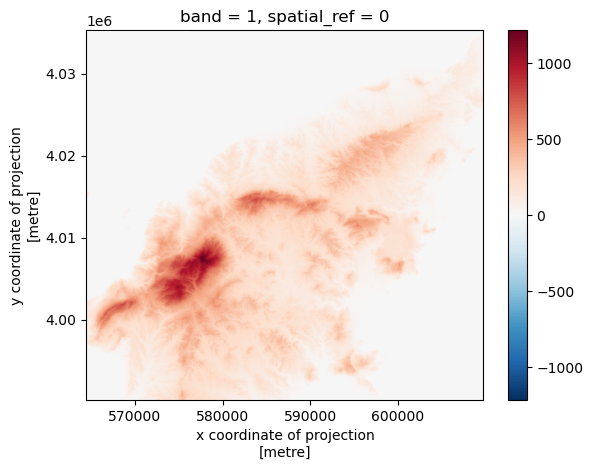

In [14]:
dem_matched.plot()

As we can see, `reproject_match` does a lot of helpful things in one line of code:

1. It reprojects.
2. It matches the extent.
3. It matches the resolution.

Finally, we can save the matched DEM for later use. We save it as a Cloud-Optimized GeoTIFF (COG) file:


In [16]:
dem_matched.rio.to_raster('dem_rhodes_match.tif', driver='COG')

## Code Tip

There is also a method in rioxarray: [`reproject()`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject), which only reprojects one raster to another projection. If you want more control over how rasters are resampled, clipped, and/or reprojected, you can use the `reproject()` method individually.

- Use `clip_box` to crop a raster with a bounding box.
- Use `clip` to crop a raster with a given polygon.
- Use `reproject_match` to match two raster datasets.